# Noise Ceiling Analysis

This script demonstrates the lower noise ceiling bound's slow convergence

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist, correlation
%matplotlib inline
print ('Imports loadaed!')

Imports loadaed!


In [2]:
# Pingoun cannot be imported, so I've copied the function here
# Copied from: https://github.com/raphaelvallat/pingouin/blob/f663e4e50e1504d8bd10030ee7da9cc38b9edd0e/pingouin/reliability.py
def cronbach_alpha(data,items=None, scores=None, subject=None,nan_policy="pairwise"):
    assert isinstance(data, pd.DataFrame), "data must be a dataframe."
    assert nan_policy in ["pairwise", "listwise"]

    if all([v is not None for v in [items, scores, subject]]):
        # Data in long-format: we first convert to a wide format
        data = data.pivot(index=subject, values=scores, columns=items)

    # From now we assume that data is in wide format
    n, k = data.shape
    assert k >= 2, "At least two items are required."
    assert n >= 2, "At least two raters/subjects are required."
    err = "All columns must be numeric."
    assert all([data[c].dtype.kind in "bfiu" for c in data.columns]), err
    if data.isna().any().any() and nan_policy == "listwise":
        # In R = psych:alpha(data, use="complete.obs")
        data = data.dropna(axis=0, how="any")

    # Compute covariance matrix and Cronbach's alpha
    C = data.cov()
    cronbach = (k / (k - 1)) * (1 - np.trace(C) / C.sum().sum())
    # which is equivalent to
    # v = np.diag(C).mean()
    # c = C.to_numpy()[np.tril_indices_from(C, k=-1)].mean()
    # cronbach = (k * c) / (v + (k - 1) * c)
    return cronbach

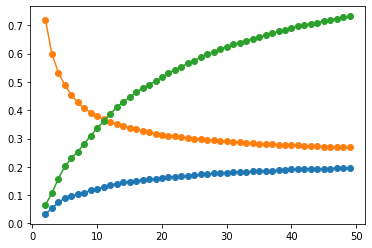

In [3]:
numPoints = 10000
numPeople = 50

rng = np.random.default_rng(42)
signal    = np.sin(np.linspace(0,2*np.pi,numPoints)) 
noise_std = 3
tmp = []
for i in range(numPeople):
    noise = rng.normal(0,noise_std,numPoints)
    tmp.append(signal + noise)
samples = np.array(tmp)

# Mean subtract and center samples
samples = samples - samples.mean(1,keepdims=True)
samples = samples / samples.std(1,keepdims=True)


# Plot lower and upper noise
def lowerN(samples):
    inds = np.arange(len(samples))
    r = np.array([1-correlation(samples[i], samples[i!=inds].mean(0)) for i in range(len(samples))])
    return r.mean()

def upperN(samples):
    tmp = samples.mean(0)
    r = np.array([1-correlation(samples[i],tmp) for i in range(len(samples))])
    return r.mean()

def cronbach(samples):
    tmp = pd.DataFrame(samples)
    a = cronbach_alpha(tmp.T)
    return a    
    
lower=[]; upper=[]; crona=[]
for i in range(2,len(samples)):
    lower.append(lowerN(samples[:i]))
    upper.append(upperN(samples[:i]))
    crona.append(cronbach(samples[:i]))
    
plt.plot(np.arange(2,len(samples)),np.c_[lower, upper, crona],'-o')

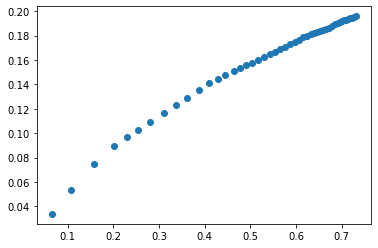

In [10]:
# Plot the two reliability metrics against eachother
plt.scatter(crona,lower)

# Verify Method

This is a sanity check to ensure that the estimated asymptotic value is (close) to the true analytic value

In [17]:
numPoints = 1000
numPeople = 500

rng = np.random.default_rng(42)
signal    = np.sin(np.linspace(0,2*np.pi,numPoints)) 
noise_std = 3
tmp = []
for i in range(numPeople):
    noise = rng.normal(0,noise_std,numPoints)
    tmp.append(signal + noise)
samples = np.array(tmp)

# Mean subtract and center samples
samples = samples - samples.mean(1,keepdims=True)
samples = samples / samples.std(1,keepdims=True)

def schope(samples):
    N = samples.shape[0]
    SP = samples.sum(0).var() - samples.var(1).sum() / (N*(N-1)) # Signal Power
    TP = (N-1)*samples.var(1).sum()
    asymptote = np.sqrt(SP/TP)
    return asymptote

def EstimateLN(subjRDMs):
    N = subjRDMs.shape[0]      # Total number of subjects
    A = subjRDMs.var(1, ddof=1).mean() # Mean of variance
    D = subjRDMs.mean(0).var()   # Variance of mean
    B = (A-(N*D))/(1-N)     # Estimated Signal Variance
    C = (A-D)/(1-(1/N))     # Estimated Noise Variance
    asymptote = B / (np.sqrt(A)*np.sqrt(B))
    return asymptote
asymptote = EstimateLN(samples)
print(f'Actual Limit: \t\t {np.sqrt(.5) / noise_std:.3f} \nEstimated Limit: \t {asymptote:.3f}')
#print(schope(samples))

Actual Limit: 		 0.236 
Estimated Limit: 	 0.229


In [7]:
np.sqrt(.5)/3

0.23570226039551587

$$ x^2 + y^2 < y |x| + 14 $$

In [14]:
.229/.236

0.9703389830508475